In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

import sys, os, math
import time
import datetime

/Users/aoxu/anaconda/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv('train.csv')
train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [3]:
len(train.place_id.unique())

108390

# Data preprocessing & visualization

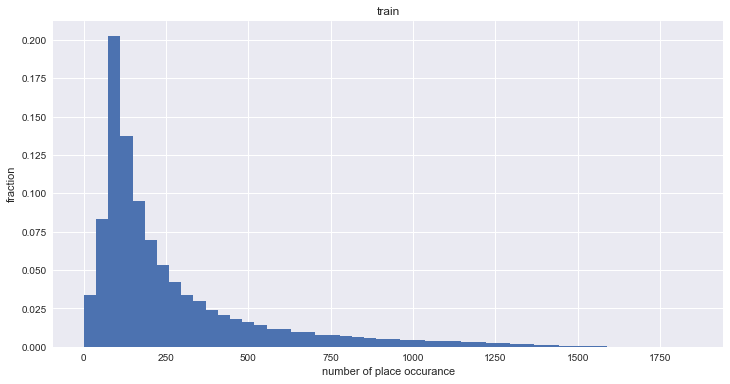

In [5]:
#### check place_id frequency ###

df_placecounts = train['place_id'].value_counts()

counts, bins = np.histogram(df_placecounts.values, bins = 50)
binsc = bins[:-1]+np.diff(bins)/2

plt.figure(3, figsize = (12,6))
plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0])
plt.grid(True)
plt.xlabel('number of place occurance')
plt.ylabel('fraction')
plt.title('train')
plt.show()

In [ ]:
### place id apprears time 



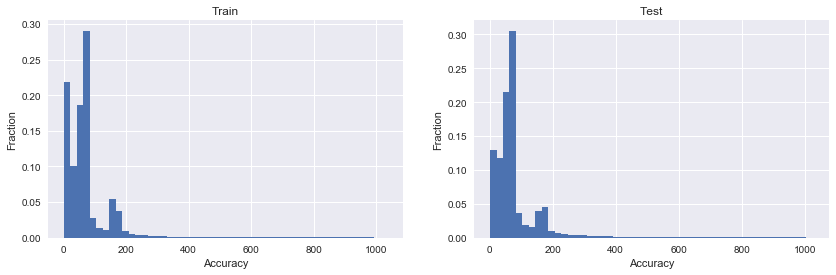

In [6]:
### check accuracy in train & test ###

counts1, bins1 = np.histogram(train['accuracy'], bins = 50)
binsc1 = bins1[:-1]+np.diff(bins1)/2

counts2, bins2 = np.histogram(test['accuracy'], bins = 50)
binsc2 = bins2[:-1]+np.diff(bins2)/2

plt.figure(0, figsize = (14,4))

plt.subplot(121)
plt.bar(binsc1, counts1/(counts1.sum()*1.0), width = np.diff(bins1)[0])
plt.grid(True)
plt.xlabel('Accuracy')
plt.ylabel('Fraction')
plt.title('Train')

plt.subplot(122)
plt.bar(binsc2, counts2/(counts2.sum()*1.0), width = np.diff(bins2)[0])
plt.grid(True)
plt.xlabel('Accuracy')
plt.ylabel('Fraction')
plt.title('Test')

plt.show()

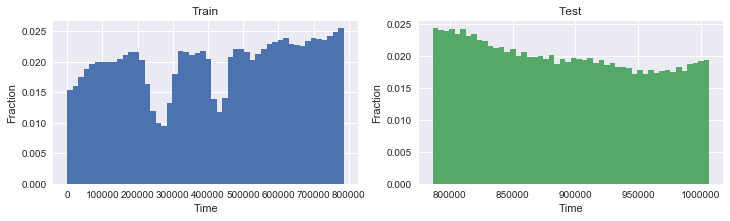

In [7]:
### check time frequency in train & test ###

current_palette = sns.color_palette()

counts1, bins1 = np.histogram(train['time'], bins = 50)
binsc1 = bins1[:-1]+np.diff(bins1)/2

counts2, bins2 = np.histogram(test['time'], bins = 50)
binsc2 = bins2[:-1]+np.diff(bins2)/2

plt.figure(1, figsize = (12,3))

plt.subplot(121)
plt.bar(binsc1, counts1/(counts1.sum()*1.0), width = np.diff(bins1)[0], color = current_palette[0])
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Fraction')
plt.title('Train')

plt.subplot(122)
plt.bar(binsc2, counts2/(counts2.sum()*1.0), width = np.diff(bins2)[0], color = current_palette[1])
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Fraction')
plt.title('Test')

plt.show()

In [76]:
## select sample which only in one-grid ##
# x in [0,1] and y in [0,1]

th = 200

df_cell_train = train[(train['x']>=0)&(train['x']<1)&
                     (train['y']>=0)&(train['y']<1)]     

###### remove infrequency place_id #######

place_counts = df_cell_train.place_id.value_counts()
mask = (place_counts[df_cell_train.place_id.values]>=th).values
df_cell_train = df_cell_train.loc[mask]

In [77]:
df_cell_train.shape

(185655, 6)

In [78]:
##### get a list of the top 20 places for future reference ####

df_placecounts = df_cell_train.place_id.value_counts()
df_placecounts = df_placecounts.sort_values(ascending = False)

In [79]:
df_topplaces = df_placecounts.iloc[0:20]

l_topplaces = list(df_topplaces.index)
print(l_topplaces)

[8507124067, 7470260459, 1511873045, 3421175639, 1254758593, 7858268564, 5861856288, 7609453580, 5108647025, 8805929689, 2411005523, 3131575096, 4682130071, 5473477945, 7123189219, 1273954023, 3662802511, 8609501758, 7408405796, 7163230644]


/Users/aoxu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


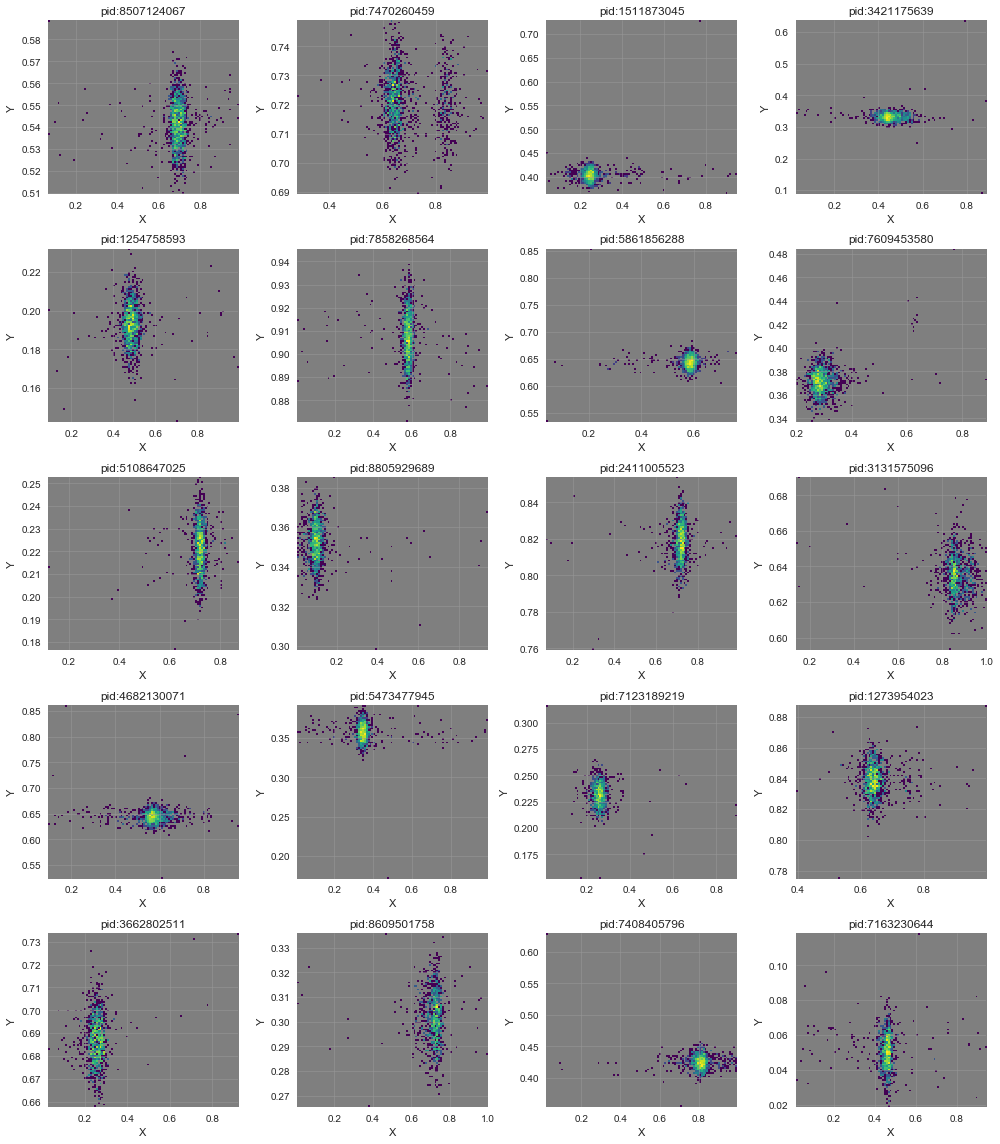

In [80]:
### check these 20 place_id`s location in (x,y) ###

plt.figure(10, figsize = (14, 16))
cmapm = plt.cm.viridis
cmapm.set_bad("0.5", 1.)

for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    df_train_place = df_cell_train[df_cell_train['place_id']==place]
    counts, binsX, binsY = np.histogram2d(df_train_place['x'], df_train_place['y'], bins=100)
    extent = [binsX.min(), binsX.max(), binsY.min(), binsY.max()]
    
    plt.subplot(5, 4, i+1)
    plt.imshow(np.log10(counts.T),
              interpolation = 'none',
              origin = 'lower',
              extent = extent,
              aspect = 'auto',
              cmap = cmapm)
    plt.grid(True, c = '0.6',lw = 0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('pid:'+str(place))

plt.tight_layout()
plt.show()

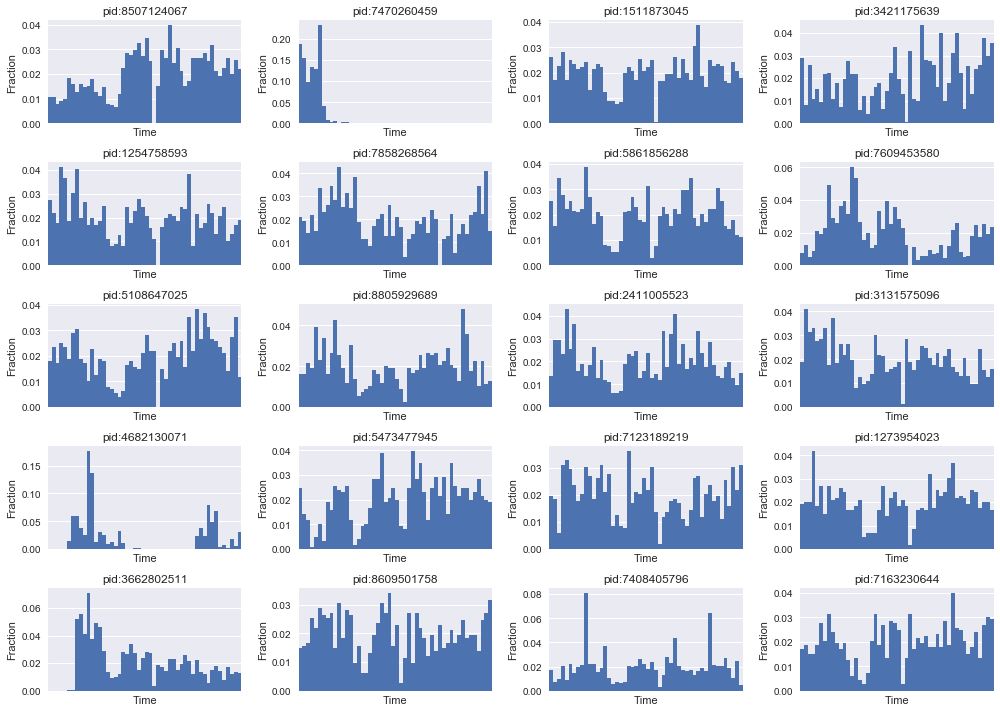

In [81]:
# check if any of the top places have time correlated visits

plt.figure(6, figsize=(14, 10))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    
    df_place = train[train['place_id'] == place]
    
    counts, bins = np.histogram(df_place['time'], bins = 50, range = [train['time'].min(), train['time'].max()])
    binsc = bins[:-1]+np.diff(bins)/2
    
    plt.subplot(5, 4, i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0])
    plt.xlim(train['time'].min(), train['time'].max())
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Fraction')
    plt.gca().get_xaxis().set_ticks([])
    plt.title('pid:'+str(place))
    
plt.tight_layout()
plt.show()

# Feature Engineering

In [4]:
th = 200

df_cell_train = train[(train['x']>=0)&(train['x']<1)&
                     (train['y']>=0)&(train['y']<1)]     


###### remove infrequency place_id #######

place_counts = df_cell_train.place_id.value_counts()
mask = (place_counts[df_cell_train.place_id.values]>=th).values
df_cell_train = df_cell_train.loc[mask]



# Add some columns to make calculations easier
#df_cell_train["hour"] = (df_cell_train["time"]//60)%24+1
#df_cell_train["week"] = (df_cell_train['time']//1440)%7+1
#df_cell_train["month"] = (df_cell_train['time']//43200)%12+1
#df_cell_train['year'] = (df_cell_train['time']//525600)+1

df_cell_train["hour"] = (df_cell_train["time"]%(60*24))/60.
df_cell_train["dayofweek"] = np.ceil((df_cell_train["time"]%(60*24*7))/(60.*24))
df_cell_train['day of month'] = np.ceil((df_cell_train['time']%(60*24*30))/(60.*24))
df_cell_train["dayofyear"] = np.ceil((df_cell_train["time"]%(60*24*365))/(60.*24))
df_cell_train.head()


fw = [500., 1000., 4., 3., 2., 8.]

#df_cell_train.loc[:,'x']*=fw[0]
#df_cell_train.loc[:,'y']*=fw[1]

df_cell_train = df_cell_train.drop(['row_id', 'time'], axis = 1)


In [5]:
df_cell_train = df_cell_train.reset_index().drop('index', axis = 1)
df_cell_train.head()

,x,y,accuracy,place_id,hour,dayofweek,day of month,dayofyear
0,0.0179,0.2321,67,8050782732,8.383333,6.0,17.0,12.0
1,0.1489,0.2586,59,5938943847,11.400000,3.0,18.0,108.0
2,0.9536,0.3766,95,7578348615,15.633333,6.0,4.0,89.0
3,0.6733,0.8339,82,1273954023,11.366667,6.0,18.0,103.0
4,0.8700,0.0681,65,7131826933,8.133333,2.0,20.0,15.0


In [6]:
######################## day of hour   ####################

mean_hour = pd.DataFrame(df_cell_train.groupby('place_id')['hour'].mean())
mean_hour.columns = ['hour_mean']
mean_hour['place_id_unique'] = mean_hour.index
mean_hour = mean_hour.reset_index(drop = True)
mean_hour[['place_id_unique']].join(mean_hour[['hour_mean']])

df_cell_train = df_cell_train.merge(mean_hour, left_on='place_id', right_on = 'place_id_unique')
df_cell_train = df_cell_train.drop('place_id_unique', axis = 1)


############################# day of month mean ########################

mean_month = pd.DataFrame(df_cell_train.groupby('place_id')['day of month'].mean())
mean_month.columns = ['dayofmonth_mean']
mean_month['place_id_unique'] = mean_month.index
mean_month = mean_month.reset_index(drop = True)
mean_month[['place_id_unique']].join(mean_month[['dayofmonth_mean']])

df_cell_train = df_cell_train.merge(mean_month, left_on='place_id', right_on = 'place_id_unique')
df_cell_train = df_cell_train.drop('place_id_unique', axis = 1)



##############################    add some features of mean of X     ###############

mean_x = df_cell_train.groupby('place_id')['x'].mean()
mean_x = pd.DataFrame(mean_x)
mean_x.columns = ['x_mean']
mean_x['place_id_unique'] = mean_x.index
mean_x = mean_x.reset_index(drop=True)
mean_x[["place_id_unique"]].join(mean_x[['x_mean']])

df_cell_train = df_cell_train.merge(mean_x, left_on='place_id', right_on = 'place_id_unique')
df_cell_train = df_cell_train.drop('place_id_unique', axis = 1)

df_cell_train.head()

,x,y,accuracy,place_id,hour,dayofweek,day of month,dayofyear,hour_mean,dayofmonth_mean,x_mean
0,0.0179,0.2321,67,8050782732,8.383333,6.0,17.0,12.0,7.156316,16.450877,0.035265
1,0.2865,0.2629,69,8050782732,9.483333,2.0,3.0,303.0,7.156316,16.450877,0.035265
2,0.0156,0.2120,167,8050782732,5.866667,3.0,18.0,108.0,7.156316,16.450877,0.035265
3,0.0202,0.2049,51,8050782732,8.666667,4.0,28.0,298.0,7.156316,16.450877,0.035265
4,0.0201,0.1937,82,8050782732,6.766667,7.0,22.0,322.0,7.156316,16.450877,0.035265


In [7]:
#############   create range for accuracy   ##########

df_accuracy = df_cell_train.accuracy

df_cell_train['range_accuracy'] = df_cell_train['accuracy'].apply(lambda x: 0 if x < 40 else (1 if x >= 40 and x < 80 else 2))

In [8]:
df_cell_train.head()

,x,y,accuracy,place_id,hour,dayofweek,day of month,dayofyear,hour_mean,dayofmonth_mean,x_mean,range_accuracy
0,0.0179,0.2321,67,8050782732,8.383333,6.0,17.0,12.0,7.156316,16.450877,0.035265,1
1,0.2865,0.2629,69,8050782732,9.483333,2.0,3.0,303.0,7.156316,16.450877,0.035265,1
2,0.0156,0.2120,167,8050782732,5.866667,3.0,18.0,108.0,7.156316,16.450877,0.035265,2
3,0.0202,0.2049,51,8050782732,8.666667,4.0,28.0,298.0,7.156316,16.450877,0.035265,1
4,0.0201,0.1937,82,8050782732,6.766667,7.0,22.0,322.0,7.156316,16.450877,0.035265,2


In [1]:
## density plot of hour, week, month, year

sns.distplot(df_cell_train['dayofweek'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

NameError: name 'sns' is not defined

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


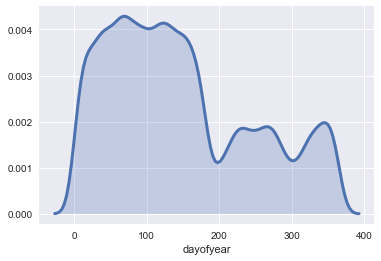

In [10]:
sns.distplot(df_cell_train['dayofyear'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

# split data

In [11]:
X = df_cell_train.drop('place_id', axis = 1)

y = pd.DataFrame(df_cell_train.place_id)

In [12]:
# normalize the dataset

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
df_normalized = pd.DataFrame(np_scaled)
df_normalized

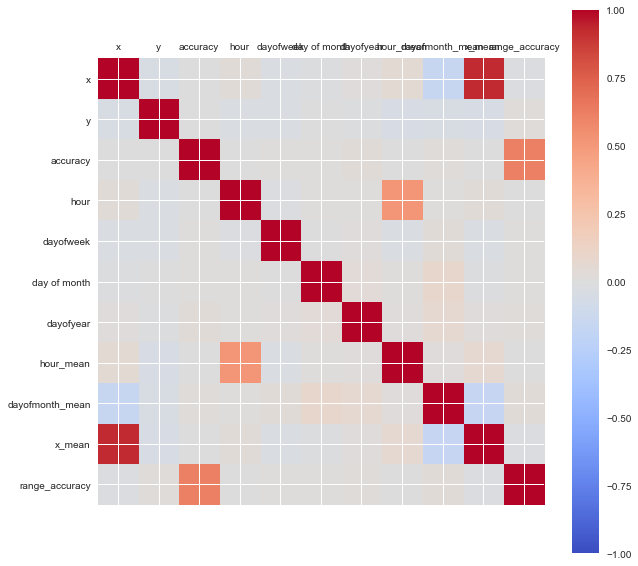

In [96]:
## plot a corrleation matric of these features

corr = df_normalized.corr()
corr

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, len(X.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

In [14]:
X.head()

,x,y,accuracy,hour,dayofweek,day of month,dayofyear,hour_mean,dayofmonth_mean,x_mean,range_accuracy
0,0.0179,0.2321,67,8.383333,6.0,17.0,12.0,7.156316,16.450877,0.035265,1
1,0.2865,0.2629,69,9.483333,2.0,3.0,303.0,7.156316,16.450877,0.035265,1
2,0.0156,0.2120,167,5.866667,3.0,18.0,108.0,7.156316,16.450877,0.035265,2
3,0.0202,0.2049,51,8.666667,4.0,28.0,298.0,7.156316,16.450877,0.035265,1
4,0.0201,0.1937,82,6.766667,7.0,22.0,322.0,7.156316,16.450877,0.035265,2


In [33]:
#  use k means cluster data points as a new feature 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 100)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X) 

In [ ]:
labels = pd.DataFrame(labels,columns=['cluster1'])
X_new = pd.concat([X, labels], axis = 1)

df_cell_train = df_cell_train.drop('place_id', axis = 1)
X_new

In [15]:
# train, test split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(148524, 11) (148524, 1)
(37131, 11) (37131, 1)


In [16]:
## prepare data

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
X_train = X_train.values.astype(float)
X_test = X_test.values.astype(float) 
y_test = le.fit_transform(y_test)

/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 2500 , weights = 'distance', metric = 'manhattan', n_jobs = 1, p = 2)
classifier.fit(X_train, y_train)

#training_time = time.clock() - start

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=2500, p=2,
           weights='distance')

In [18]:
y_pred_knn = classifier.predict(X_test)

In [19]:
from sklearn import metrics

print('accuracy:', metrics.accuracy_score(y_test, y_pred_knn))

accuracy: 0.11141633675365598


In [112]:
#### let`s try the cross validation do the parameter tuning 

# create odd list of K for cross validation

scores = cross_val_score(classifier, X, y, cv = 5)
print('cross-validate score:', scores)

/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWa

cross-validate score: [0.13668293 0.13408407 0.13542705 0.13305799 0.13870409]


# Random forest

In [67]:
###### random forest #######

from sklearn.ensemble import RandomForestClassifier

# create a gaussian classifier

#rf = RandomForestClassifier(n_estimators = 10)

#rf.fit(X_train, y_train)

#y_pred_rf = rf.predict(X_test)

def modelfit(rf, X_train, y_train, performCV = True, printFeatureImportance = True, cv_folds = 5):
    # fit the algorithm on the data
    rf.fit(X_train, y_train)
    
    # predict training set
    y_pred_gb = alg.predict(X_train)
    y_pred_prob = alg.predict_proba(X_train)
    
    # perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(rf, X_train, y_train, cv = cv_folds, scoring = 'roc_auc')
        
    # print model report
    print('accuracy:'% metrics.accuracy_score(y_train, y_pred_gb))
    print('auc score:'% metrics.roc_auc_score(y_train, y_pred_prob))
    
    # print feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(rf.feature_importances_, X_train).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'features importance')
        plt.ylabel('feature importance score')

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42, max_depth = 3, )
rf.fit(X_train, y_train)

/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
y_pred_rf = rf.predict(X_test)

In [23]:
from sklearn import metrics

print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

accuracy: 0.3025234978858636


# Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_NB = nb.predict(X_test)
y_pred_NB

array([331, 316, 325, ..., 171,  59,  50])

In [25]:
print(accuracy_score(y_test, y_pred_NB))

1.0


In [26]:
count = 0
for i in range(len(y_pred_NB)):
    if y_pred_NB[i] == y_test[i]:
        count = count + 1
acc = count/len(y_pred_NB)
acc

1.0

# Boosting 

In [28]:
# adaboost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
adaboost = AdaBoostClassifier(base_estimator = model_dt, n_estimators = 400, learning_rate = 1)
adaboost.fit(X_train, y_train)
y_pred_ada = adaboost.predict(X_test) 

print('accuracy:', metrics.accuracy_score(y_test, y_pred_ada))

accuracy: 0.05531765909886618


In [53]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

def modelfit(alg, X_train, y_train, performCV = True, printFeatureImportance = True, cv_folds = 5):
    # fit the algorithm on the data
    alg.fit(X_train, y_train)
    
    # predict training set
    y_pred_gb = alg.predict(X_train)
    y_pred_prob = alg.predict_proba(X_train)
    
    # perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv = cv_folds, scoring = 'roc_auc')
        
    # print model report
    print('accuracy:'% metrics.accuracy_score(y_train, y_pred_gb))
    print('auc score:'% metrics.roc_auc_score(y_train, y_pred_prob))
    
    # print feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'features importance')
        plt.ylabel('feature importance score')


In [66]:
gbm = GradientBoostingClassifier(random_state = 10)
modelfit(gbm, X_test, y_test)

/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [30]:
### XG boost

import xgboost as xgb

xg_class = xgb.XGBClassifier(colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha = 10, n_estimators=10)
xg_class.fit(X_train, y_train)

y_pred_xgb = xg_class.predict(X_test)
print('accuracy:', metrics.accuracy_score(y_test, y_pred_xgb))

accuracy: 0.9797204492203281


/Users/aoxu/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ImportError: You must install graphviz to plot tree

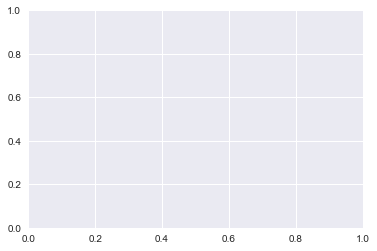

In [31]:
# plot the tree

xgb.plot_tree(xg_class, num_trees = 0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()